# Plot Comupute Statistics for OSG Job

In [165]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import multiprocessing
import h5py
from datetime import datetime, timedelta
import os

In [166]:
import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [16, 16]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.2
mpl.rcParams['figure.subplot.hspace'] = 0.25
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [167]:
def get_field_MP(inputs):
    """
    Function for MultiProcessing.
    Return the value from a key in the HDF5 file array
    """
    FILE, STAT = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT].value
    except:
        #print "missing:", FILE
        return np.nan

In [194]:
var = 'UVGRD:10 m'

variable = var.replace(':', '_').replace(' ', '_')

DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % variable
print DIR

/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/UVGRD_10_m/


In [195]:
months = range(1,13)
days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
hours = range(24)

# Dates (with leap year)
HOURS = 366*24
DATES = np.array([datetime(2016, 1, 1) + timedelta(hours = h) for h in range(HOURS)])

In [196]:
# Get compute statistics from every file
      
# Multiprocessing :)
cores = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
        (variable, month, day, hour), 'cores'] \
        for month in months for day in range(1,days[month-1]+1) for hour in hours]

count = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
        (variable, month, day, hour), 'count'] \
        for month in months for day in range(1,days[month-1]+1) for hour in hours]

timer = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
        (variable, month, day, hour), 'timer'] \
        for month in months for day in range(1,days[month-1]+1) for hour in hours]

num_proc = multiprocessing.cpu_count()
p = multiprocessing.Pool(num_proc)
cores = np.array(p.map(get_field_MP, cores))
count = np.array(p.map(get_field_MP, count))
timer = np.array(p.map(get_field_MP, timer))
p.close()

In [197]:
# Convert timer to seconds
Timer = []
for t in timer:
    try:
        Timer.append(int(t.split(':')[0])*86400 + int(t.split(':')[1])*60 + float(t.split(':')[2]))
    except:
        Timer.append(np.nan)

## Cores vs. DATE

1 Missing Files
8784 Total Files
Average compute time per file: 116.89 seconds


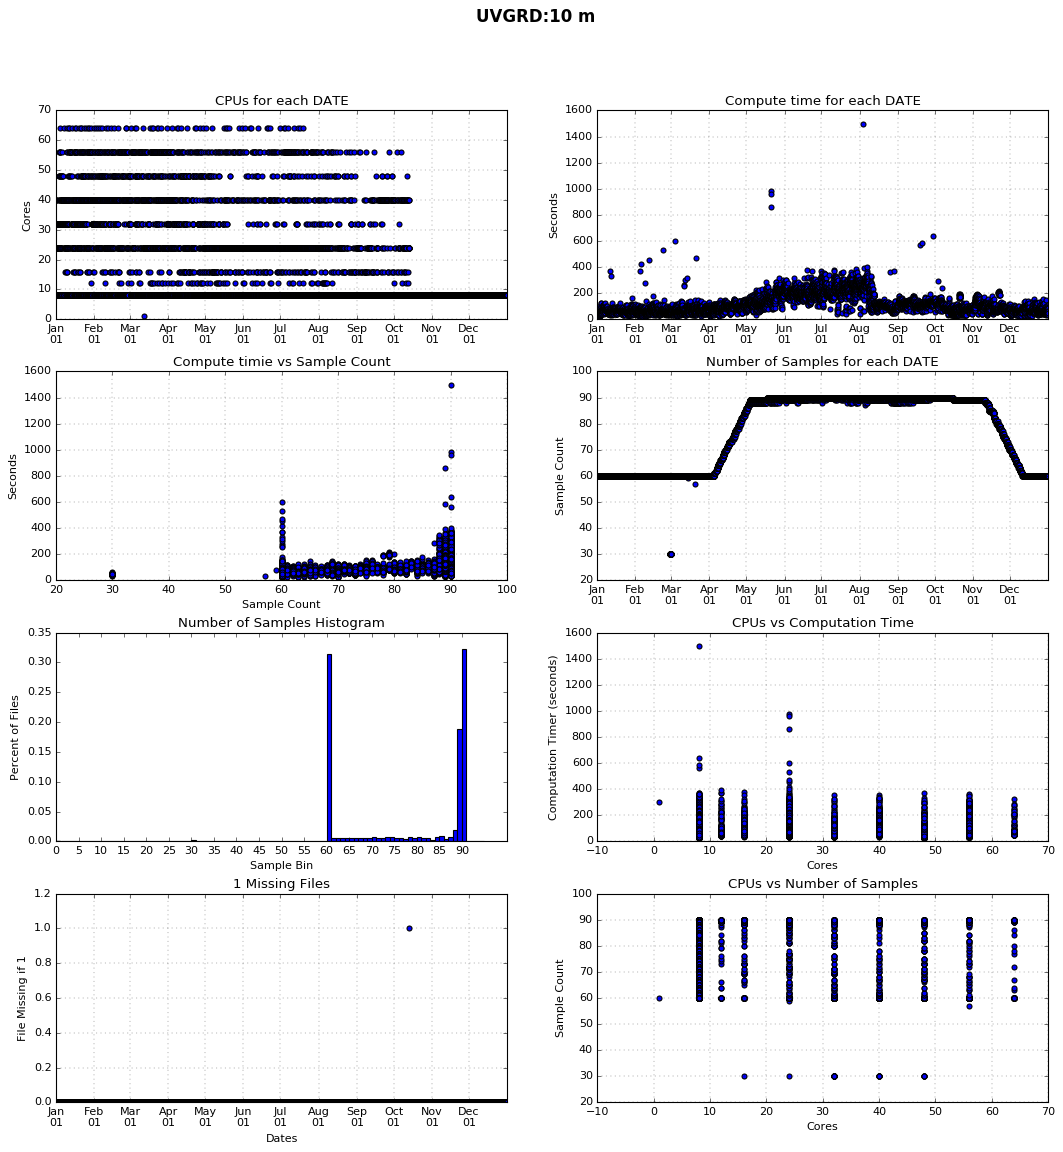

In [200]:


fig, axes = plt.subplots(4, 2)
plt.suptitle(var)

formatter = DateFormatter('%b\n%d')

axes[0,0].set_title('CPUs for each DATE')
axes[0,0].scatter(DATES, cores)
axes[0,0].set_ylabel('Cores')
axes[0,0].xaxis.set_major_formatter(formatter)
axes[0,0].grid()
axes[0,0].set_xlim(DATES[0], DATES[-1])
axes[0,0].set_ylim(ymin=0)

axes[0,1].set_title('Compute time for each DATE')
axes[0,1].scatter(DATES, Timer)
axes[0,1].set_ylabel('Seconds')
axes[0,1].xaxis.set_major_formatter(formatter)
axes[0,1].grid()
axes[0,1].set_xlim(DATES[0], DATES[-1])
axes[0,1].set_ylim(ymin=0)

axes[1,0].set_title('Compute timie vs Sample Count')
axes[1,0].scatter(count, Timer)
axes[1,0].set_xlabel('Sample Count')
axes[1,0].set_ylabel('Seconds')
axes[1,0].grid()
axes[1,0].set_ylim(ymin=0)

axes[1,1].set_title('Number of Samples for each DATE')
axes[1,1].scatter(DATES, count)
axes[1,1].set_ylabel('Sample Count')
axes[1,1].xaxis.set_major_formatter(formatter)
axes[1,1].grid()
axes[1,1].set_xlim(DATES[0], DATES[-1])

axes[2,0].set_title('Number of Samples Histogram')
a = axes[2,0].hist(count, bins=95, range=[0,95], normed=True)
axes[2,0].set_ylabel('Percent of Files')
axes[2,0].set_xlabel('Sample Bin')
b=axes[2,0].set_xticks(range(0,95,5))
axes[2,0].set_ylim(ymin=0)

axes[2,1].set_title('CPUs vs Computation Time')
axes[2,1].scatter(cores, Timer)
axes[2,1].set_xlabel('Cores')
axes[2,1].set_ylabel('Computation Timer (seconds)')
axes[2,1].grid()
axes[2,1].set_ylim(ymin=0)

# Number of missing files
NANS = []
for a in cores:
    if np.isnan(a):
        NANS.append(1)
    else:
        NANS.append(0)

print "%s Missing Files" % np.sum(NANS)

axes[3,0].set_title('%s Missing Files' % np.sum(NANS))
axes[3,0].scatter(DATES, NANS)
axes[3,0].set_xlabel('Dates')
axes[3,0].set_ylabel('File Missing if 1')
axes[3,0].grid()
axes[3,0].set_ylim(ymin=0)
axes[3,0].set_xlim([DATES[0],DATES[-1]])
axes[3,0].xaxis.set_major_formatter(formatter)

axes[3,1].set_title('CPUs vs Number of Samples')
axes[3,1].scatter(cores, count)
axes[3,1].set_xlabel('Cores')
axes[3,1].set_ylabel('Sample Count')
axes[3,1].grid()

print len(os.listdir(DIR)), "Total Files"
print 'Average compute time per file: %.2f seconds' % np.nanmean(Timer)
plt.savefig('OSG_%s_JobStats.png' % var.replace(':','').replace(' ',''))